# Use Case 5: Gene Set Enrichment Analysis

This use case will demonstrate the process of Gene Set Enrichment Analysis (GSEA) on protein data obtained from clinical and proteomics dataframes. The aim is to identify the upregulated genes in tumor and normal tissue samples and determine their enriched biological pathways. We will use the gseapy library for GSEA, the cptac package for accessing the CPTAC datasets, and the usual data science libraries for data manipulation and visualization.

## Step 1: Importing packages and setting up your notebook.

The Python environment needs several libraries for data manipulation and visualization. We also initialize the cptac endometrial dataset (Ucec).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import gseapy as gp
from gseapy.plot import barplot, dotplot

import cptac
en = cptac.Ucec()

## Step 2: Joining dataframes

We join the clinical and proteomics data using the join_metadata_to_omics function. We specifically focus on the 'type_of_analyzed_samples' column to differentiate between tumor and non-tumor samples.

In [2]:
tumorProt = en.join_metadata_to_omics(
    metadata_name="clinical",
    metadata_source='mssm',
    metadata_cols='type_of_analyzed_samples',
    omics_name="proteomics",
    omics_source='umich'
)

## Step 3: Data Segregation

To prepare the data for analysis, we split the proteomics data into two separate dataframes, one for tumor samples and another for normal samples. We take an inclusive approach and categorize everything other than explicitly labeled "Tumor" samples as "Normal".

In [3]:
# Drop the second instance of the duplicated column
tumorProt = tumorProt.loc[:,~tumorProt.columns.duplicated()]

# Retrieve boolean array of true values for tumor and normal samples
tumor_bool = tumorProt['type_of_analyzed_samples_mssm_clinical'] == "Tumor"
normal_bool = tumorProt['type_of_analyzed_samples_mssm_clinical'] != "Tumor"

# Use boolean array to select for appropriate patients
tumor = tumorProt[tumor_bool]
normal = tumorProt[normal_bool]

## Step 4: Performing Welch's t-test

To identify upregulated genes, we use Welch's t-test, a version of the two-sample t-test that accommodates different variances between two groups. In our case, we compare the gene abundance of "Tumor" and "Normal" groups for each gene. Genes with a significant p-value after correction for multiple testing are considered upregulated, and their expression patterns (i.e., higher in tumor or normal samples) are noted.

In [4]:
# Create array variables to hold the significant genes for each partition
tumor_genes = []
normal_genes = []

# Grab the genes of interest, ignoring the MSI column in the dataframe
genes = tumor.columns[1:]

# Correct alpha level for multiple testing by dividing the standard .05 by the number of genes to be analyzed
threshold = .05 / len(genes)

# Perform Welch's t-test (different variances) on each gene between the two groups
for gene in genes:
    tumor_gene_abundance = tumor[gene]
    normal_gene_abundance = normal[gene]
    
    if len(tumor_gene_abundance.shape) > 1 or len(normal_gene_abundance.shape) > 1:
        # take the mean across the columns
        tumor_gene_abundance = tumor_gene_abundance.mean(axis=1)
        normal_gene_abundance = normal_gene_abundance.mean(axis=1)
    
    pvalue = stats.ttest_ind(tumor_gene_abundance, normal_gene_abundance, equal_var=False, nan_policy='omit').pvalue
    # If the P-value is significant, determine which partition is more highly expressed
    if pvalue < threshold:
        if tumor_gene_abundance.mean() > normal_gene_abundance.mean():
            tumor_genes.append(gene.split("_")[0])
        elif normal_gene_abundance.mean() > tumor_gene_abundance.mean():
            normal_genes.append(gene.split("_")[0])

print("Proteomics Tumor Genes:", len(tumor_genes))
print("Proteomics Normal Genes:", len(normal_genes))

Proteomics Tumor Genes: 662
Proteomics Normal Genes: 921


## Step 5: Gene set enrichment analysis (GSEA)

With our list of upregulated genes, we perform a GSEA using the enrichr() function from the gseapy library. This analysis identifies biological pathways that are overrepresented in our list of genes, providing insight into potential molecular mechanisms at play.

In [5]:
tumor_enr = gp.enrichr(gene_list=tumor_genes, gene_sets='KEGG_2016', outdir='test/enrichr_kegg_tumor')
normal_enr = gp.enrichr(gene_list=normal_genes, gene_sets='KEGG_2016', outdir='test/enrichr_kegg_normal')

# View the data as a table
print(tumor_enr.res2d.head())
print(normal_enr.res2d.head())

    Gene_set                                               Term Overlap  \
0  KEGG_2016                   Proteasome Homo sapiens hsa03050   17/44   
1  KEGG_2016                     Lysosome Homo sapiens hsa04142  16/123   
2  KEGG_2016  Amino sugar and nucleotide sugar metabolism Ho...   10/48   
3  KEGG_2016                RNA transport Homo sapiens hsa03013  18/172   
4  KEGG_2016  Epstein-Barr virus infection Homo sapiens hsa0...  18/202   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  1.673514e-14      3.531115e-12            0                     0   
1  3.060119e-06      2.176135e-04            0                     0   
2  3.094031e-06      2.176135e-04            0                     0   
3  1.686874e-05      8.898263e-04            0                     0   
4  1.399243e-04      5.904807e-03            0                     0   

   Odds Ratio  Combined Score  \
0   18.850818      597.971810   
1    4.451492       56.520842   
2    7.789797    

## Step 6: Visualizing Enrichment Results

We create barplots to visualize the GSEA results, giving us a better understanding of the pathways significantly associated with the upregulated genes in both the tumor and normal tissue groups.

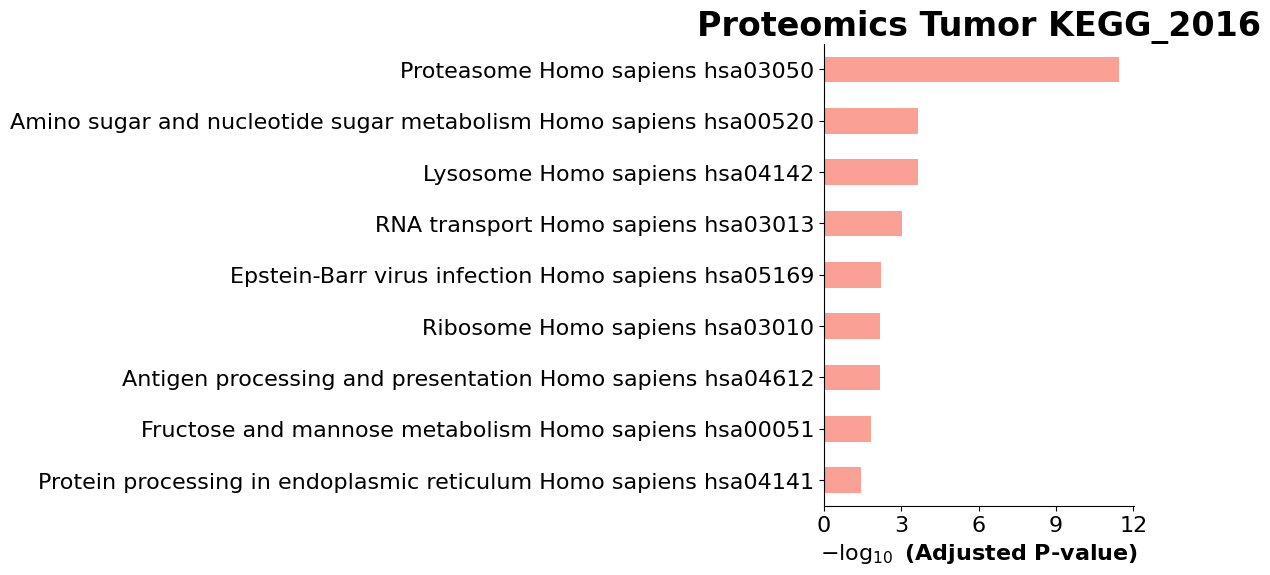

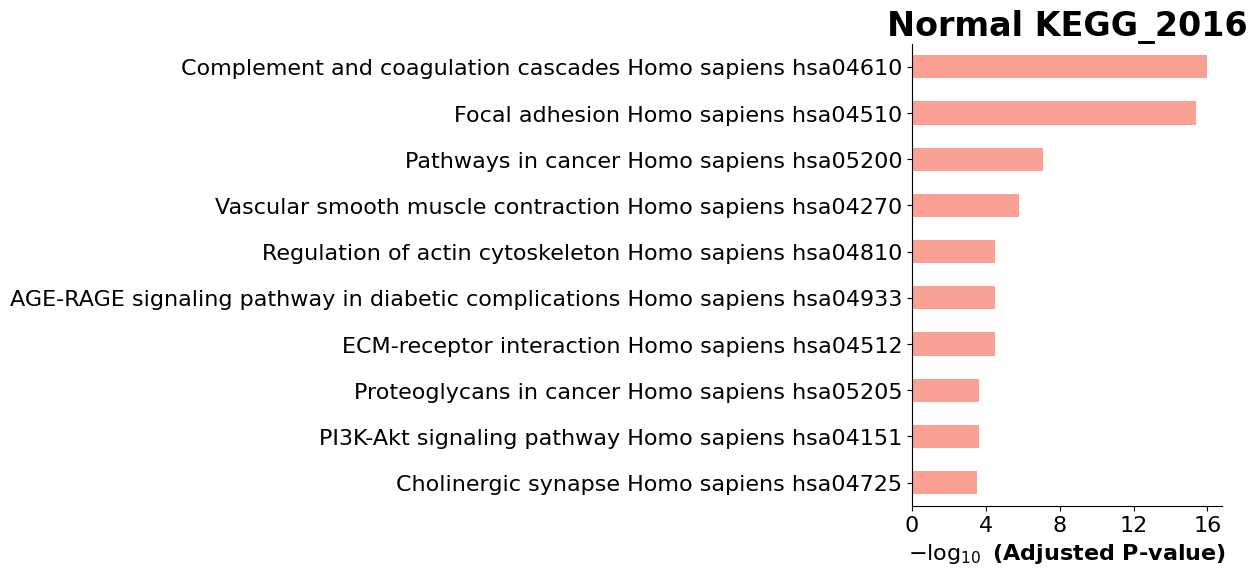

In [6]:
barplot(tumor_enr.res2d, title="Proteomics Tumor KEGG_2016")
plt.show()

barplot(normal_enr.res2d, title="Normal KEGG_2016")
plt.show()

## Discussion

This use case illustrates how to conduct a GSEA using the gseapy library and the cptac package. The resulting barplots provide an intuitive visualization of the enriched pathways among upregulated genes in both tumor and normal samples. These identified pathways could potentially offer valuable insights into the biological processes involved in tumor development and the body's response in normal tissues. Further research can be conducted on these significantly enriched pathways for a more detailed understanding of their roles in tumorigenesis.